# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Lis Wahyuni
- **Email:** liswyuni@gmail.com
- **ID Dicoding:** liswahyuni

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Load libraries
import os
import cv2
import numpy as np
import urllib.request
from PIL import Image
import tensorflow as tf
from typing import Tuple
import matplotlib.pyplot as plt
from warnings import filterwarnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Convolution2D, MaxPool2D, Flatten, Dropout, BatchNormalization
import tensorflowjs as tfjs

from google.colab import drive
filterwarnings("ignore")
drive.mount('/content/drive')

## Data Preparation

In [2]:
# Copy internal .zip file into current runtime collabs
!cp "/content/drive/MyDrive/Dataset Dicoding/seg_data.zip" .

In [3]:
# Check file on our runtime
!ls

drive  sample_data  seg_data.zip


### Data Loading

In [4]:
# Unzip data
!unzip seg_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_data/seg_train/seg_train/mountain/16164.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._16164.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/3358.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._3358.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/2720.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._2720.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/14029.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._14029.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/14997.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._14997.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/1567.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._1567.jpg  
  inflating: seg_data/seg_train/seg_train/mountain/11637.jpg  
  inflating: __MACOSX/seg_data/seg_train/seg_train/mountain/._11637.jp

In [5]:
# Check extracted file from .zip file
!ls

drive  __MACOSX  sample_data  seg_data	seg_data.zip


### Data Preprocessing

In [87]:
# Define base directory and paths
base_dir = 'seg_data'
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')
pred_dir = os.path.join(base_dir, 'seg_pred/seg_pred')

used_class = ["forest", "glacier", "mountain", "sea", "street"]
def prepare_dataset(directory, target_size=(32, 32)):
    images = []
    labels = []

    class_names = used_class

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue

        for img_file in os.listdir(class_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')

                    # Preserve aspect ratio while resizing
                    img.thumbnail(target_size)

                    # Create new image with padding to maintain consistent size
                    new_img = Image.new('RGB', target_size, (0, 0, 0))
                    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                                      (target_size[1] - img.size[1]) // 2))

                    img_array = np.array(new_img) / 255.0
                    images.append(img_array)
                    labels.append(class_idx)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Check dataset resolution and count
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
    class_counts = {}

    for class_name in used_class:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path)
                      if f.endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
        total_images += len(image_files)

        for img_file in image_files[:5]:
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
    print(f"\nTotal images: {total_images}")
    print("\nSample of unique image sizes:")
    for size in unique_sizes:
        print(f"- {size}")

# Check training dataset
print("Analyzing training dataset:")
print_images_resolution(train_dir)

Analyzing training dataset:
Class distribution:
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images

Total images: 11843

Sample of unique image sizes:
- (150, 150)


Analyzing image resolutions in training dataset:
Number of different resolutions found: 31

Unique resolutions (width x height):
- 150x76 pixels: 1 images
- 150x81 pixels: 1 images
- 150x97 pixels: 1 images
- 150x100 pixels: 1 images
- 150x102 pixels: 1 images
- 150x103 pixels: 1 images
- 150x105 pixels: 1 images
- 150x108 pixels: 2 images
- 150x110 pixels: 1 images
- 150x111 pixels: 3 images
- 150x113 pixels: 7 images
- 150x115 pixels: 1 images
- 150x119 pixels: 1 images
- 150x120 pixels: 1 images
- 150x123 pixels: 2 images
- 150x124 pixels: 1 images
- 150x131 pixels: 1 images
- 150x133 pixels: 1 images
- 150x134 pixels: 2 images
- 150x135 pixels: 3 images
- 150x136 pixels: 2 images
- 150x140 pixels: 1 images
- 150x141 pixels: 1 images
- 150x142 pixels: 2 images
- 150x143 pixels: 2 images
- 150x144 pixels: 2 images
- 150x145 pixels: 1 images
- 150x146 pixels: 2 images
- 150x147 pixels: 1 images
- 150x149 pixels: 1 images
- 150x150 pixels: 13986 images


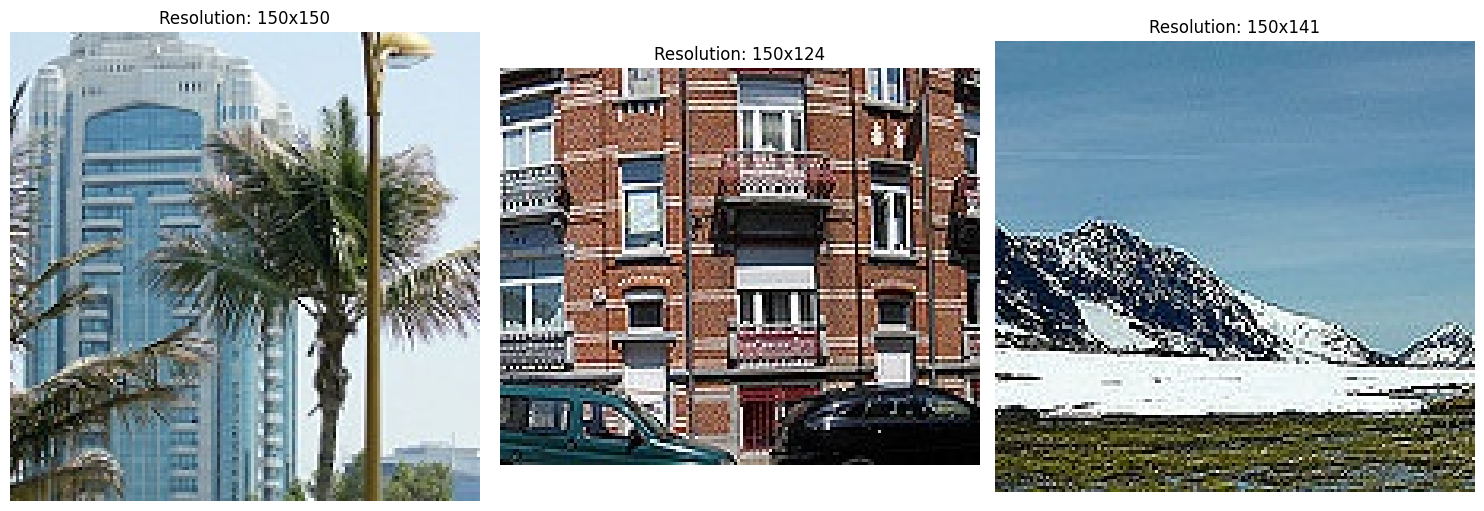

In [10]:
def analyze_image_resolutions(directory):
    resolutions = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    resolutions.append(img.size)

    # Convert to numpy array for analysis
    resolutions = np.array(resolutions)

    # Print unique resolutions
    unique_resolutions = np.unique(resolutions, axis=0)
    print(f"Number of different resolutions found: {len(unique_resolutions)}")
    print("\nUnique resolutions (width x height):")
    for res in unique_resolutions:
        count = np.sum(np.all(resolutions == res, axis=1))
        print(f"- {res[0]}x{res[1]} pixels: {count} images")

    # Visualize sample images with different resolutions
    plt.figure(figsize=(15, 5))
    shown_resolutions = set()
    plot_idx = 1

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    if img.size not in shown_resolutions and len(shown_resolutions) < 3:
                        plt.subplot(1, 3, plot_idx)
                        plt.imshow(img)
                        plt.title(f"Resolution: {img.size[0]}x{img.size[1]}")
                        plt.axis('off')
                        shown_resolutions.add(img.size)
                        plot_idx += 1

    plt.tight_layout()
    plt.show()

# Analyze training dataset
print("Analyzing image resolutions in training dataset:")
analyze_image_resolutions(train_dir)

#### Split Dataset

In [11]:
# Load dataset into feature and label based on training set.
X, y, class_name = prepare_dataset(directory=train_dir, target_size=(32, 32))
X.shape, y.shape, len(class_name), np.unique(y)

((11843, 32, 32, 3), (11843,), 5, array([0, 1, 2, 3, 4]))

In [12]:
# Split dataset into training and validation set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9474, 32, 32, 3), (2369, 32, 32, 3), (9474,), (2369,))

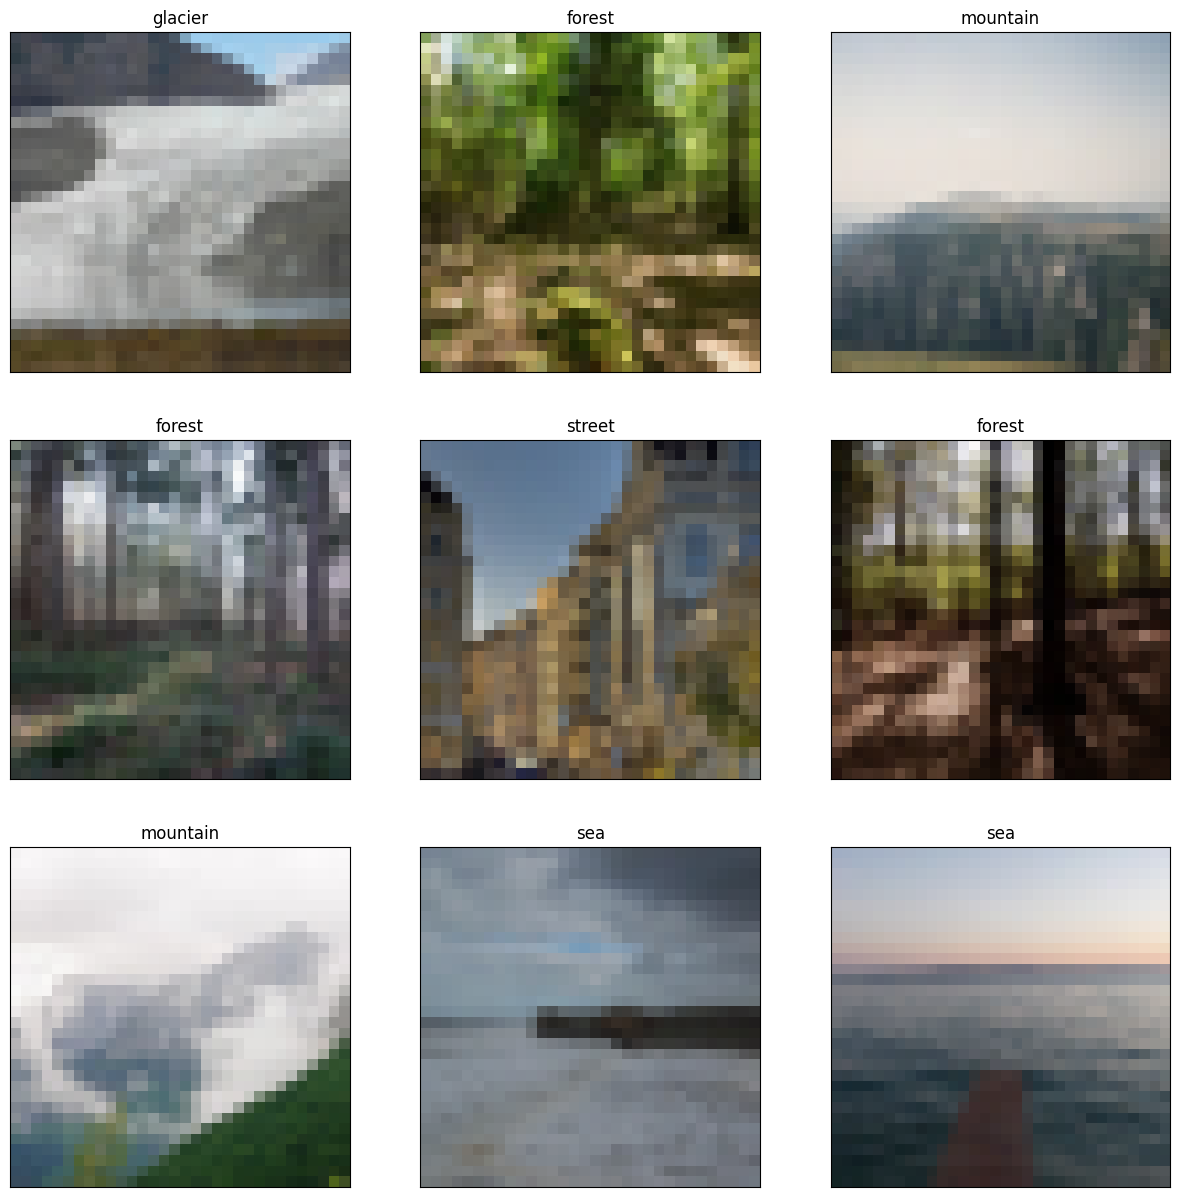

In [13]:
plt.figure(figsize=(15,15))

# Loop over the first 9 images
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    cls_index = y_train[i]
    label_name = class_name[cls_index]
    plt.title(label_name, fontsize=12)

# Display the figure
plt.show()

In [14]:
# Casting image feature
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# Normalize pixel variation based on mean and std. dev. of training set
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / (std + 1e-7)
X_val = (X_val - mean) / (std + 1e-7)

# Check dimension
X_train.shape, X_val.shape

((9474, 32, 32, 3), (2369, 32, 32, 3))

In [15]:
# Apply One Hot Encoding into Labels
n_classes = len(class_name)
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

# Check dimension
y_train_cat.shape, y_val_cat.shape

((9474, 5), (2369, 5))

## Modelling

In [48]:
# Create CNN Architecture
def create_cnn_model(input_shape: Tuple[int, int, int], num_classes: int, weight_decay: float = 0.0001) -> tf.keras.Model:
    model = Sequential(
        [
            Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=input_shape),
            BatchNormalization(),
            Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            MaxPool2D(pool_size=(2,2)),
            Dropout(rate=0.2),
            Convolution2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=input_shape),
            BatchNormalization(),
            Convolution2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            MaxPool2D(pool_size=(2,2)),
            Dropout(rate=0.2),
            Convolution2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            Convolution2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            MaxPool2D(pool_size=(2,2)),
            Dropout(rate=0.2),
            Convolution2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            Convolution2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay)),
            BatchNormalization(),
            MaxPool2D(pool_size=(2,2)),
            Dropout(rate=0.2),
            Flatten(),
            Dropout(rate=0.2),
            Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [56]:
# Instantiate model architecture
model = create_cnn_model(input_shape=(32, 32, 3), num_classes=5)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,228,485 (4.69 MB)

 Trainable params: 1,226,437 (4.68 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [57]:
# Define hyperparameter for training
EPOCHS: int = 250
BATCH_SIZE: int = 64
optimizer = Adam(learning_rate=5e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

In [58]:
# Compile model CNN with optimizer, loss, and metrics evaluation
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [59]:
# Training model CNN
history = model.fit(
    x=X_train, y=y_train_cat,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_cat),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)

Epoch 1/250
149/149 - 23s - 154ms/step - accuracy: 0.6233 - loss: 1.3331 - val_accuracy: 0.3670 - val_loss: 1.8829 - learning_rate: 5.0000e-04
Epoch 2/250
149/149 - 2s - 15ms/step - accuracy: 0.7197 - loss: 0.8460 - val_accuracy: 0.4288 - val_loss: 1.5975 - learning_rate: 5.0000e-04
Epoch 3/250
149/149 - 2s - 17ms/step - accuracy: 0.7675 - loss: 0.7198 - val_accuracy: 0.7643 - val_loss: 0.7157 - learning_rate: 5.0000e-04
Epoch 4/250
149/149 - 2s - 15ms/step - accuracy: 0.7887 - loss: 0.6594 - val_accuracy: 0.8419 - val_loss: 0.4889 - learning_rate: 5.0000e-04
Epoch 5/250
149/149 - 2s - 16ms/step - accuracy: 0.8122 - loss: 0.6064 - val_accuracy: 0.8879 - val_loss: 0.4062 - learning_rate: 5.0000e-04
Epoch 6/250
149/149 - 2s - 15ms/step - accuracy: 0.8261 - loss: 0.5642 - val_accuracy: 0.8390 - val_loss: 0.5177 - learning_rate: 5.0000e-04
Epoch 7/250
149/149 - 3s - 17ms/step - accuracy: 0.7931 - loss: 0.6713 - val_accuracy: 0.9042 - val_loss: 0.3491 - learning_rate: 5.0000e-04
Epoch 8/250

## Evaluasi dan Visualisasi

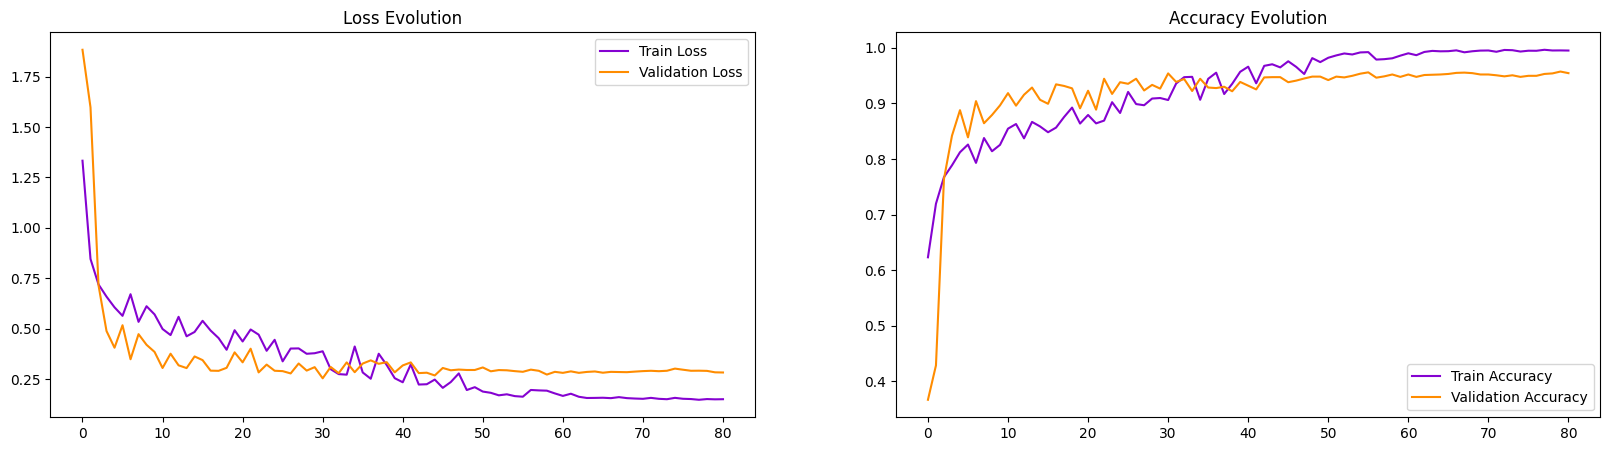

In [60]:
plt.figure(figsize=(20, 5))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [61]:
# Evaluate on validation sampling and show the classification report and confusion matrix
y_pred_cat = model.predict(X_val)
print("Classification Report:\n")
print(classification_report(y_val_cat.argmax(axis=1), y_pred_cat.argmax(axis=1), target_names=class_name))
print("Confusion Matrix:\n")
print(confusion_matrix(y_val_cat.argmax(axis=1), y_pred_cat.argmax(axis=1)))

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Classification Report:

              precision    recall  f1-score   support

      forest       0.96      0.99      0.98       433
     glacier       0.93      0.94      0.93       387
    mountain       0.94      0.91      0.93       422
         sea       0.96      0.95      0.96       402
      street       0.98      0.97      0.97       443

    accuracy                           0.95      2087
   macro avg       0.95      0.95      0.95      2087
weighted avg       0.95      0.95      0.95      2087

Confusion Matrix:

[[430   0   0   0   3]
 [  1 362  16   6   2]
 [  3  21 386  10   2]
 [  1   6   9 383   3]
 [ 11   1   1   0 430]]


In [83]:
# Load dataset into feature and label based on testing set.
X_test, y_test, class_name = prepare_dataset(directory=test_dir, target_size=(32, 32))
X_test = (X_test - mean) / (std + 1e-7)
X_test.shape, y_test.shape, class_name

((2275, 32, 32, 3),
 (2275,),
 ['forest', 'glacier', 'mountain', 'sea', 'street'])

In [84]:
# Evaluate on test set.
y_pred_test = model.predict(X_test, verbose=1)
print("Classification Report:\n")
print(classification_report(y_test, y_pred_test.argmax(axis=1), target_names=class_name))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_test.argmax(axis=1)))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:

              precision    recall  f1-score   support

      forest       1.00      0.97      0.99       474
     glacier       0.99      0.93      0.96       482
    mountain       0.95      1.00      0.98       417
         sea       0.97      1.00      0.99       434
      street       0.97      1.00      0.99       468

    accuracy                           0.98      2275
   macro avg       0.98      0.98      0.98      2275
weighted avg       0.98      0.98      0.98      2275

Confusion Matrix:

[[460   3   2   1   8]
 [  0 446  18  12   6]
 [  0   0 417   0   0]
 [  0   0   0 434   0]
 [  0   0   0   0 468]]


## Konversi Model

In [105]:
os.makedirs('tfjs_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)

In [106]:
# Save the TensorFlow.js model
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [107]:
# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('tflite/model.tflite', 'wb') as f:
  f.write(tflite_model)

# Save the labels (class names)
with open('tflite/label.txt', 'w') as f:
  for class_name in used_class:
    f.write(class_name + '\n')

Saved artifact at '/tmp/tmpz7vfdgdd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_140')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132094035777808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132094035772816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132096783669904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132096783670288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132094035787024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132096783671248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132096783674128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132096783674896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132095189593040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132095189589968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132095189586

In [110]:
# Save the model using TensorFlow's SavedModel format
tf.saved_model.save(model, 'saved_model')

## Inference (Optional)

In [112]:
# Load the TF-Lite model
interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()

In [113]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [124]:
# Load the labels (class names)
with open('tflite/label.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Process only the first 5 images in pred_dir
image_files = [f for f in os.listdir(pred_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:10]

print("Number of images found:", len(image_files))

Number of images found: 10


Loading image: seg_data/seg_pred/seg_pred/9713.jpg


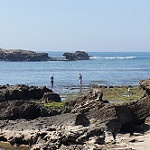

Prediction: sea
Loading image: seg_data/seg_pred/seg_pred/22443.jpg


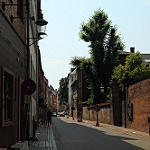

Prediction: glacier
Loading image: seg_data/seg_pred/seg_pred/6453.jpg


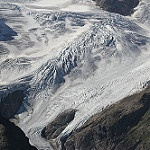

Prediction: mountain
Loading image: seg_data/seg_pred/seg_pred/22751.jpg


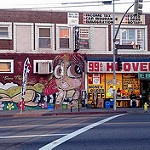

Prediction: glacier
Loading image: seg_data/seg_pred/seg_pred/15010.jpg


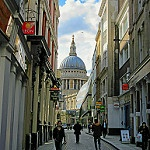

Prediction: glacier
Loading image: seg_data/seg_pred/seg_pred/21010.jpg


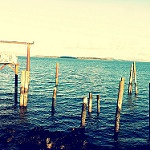

Prediction: mountain
Loading image: seg_data/seg_pred/seg_pred/11942.jpg


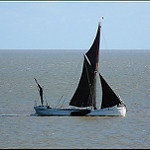

Prediction: glacier
Loading image: seg_data/seg_pred/seg_pred/13014.jpg


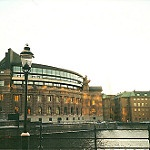

Prediction: mountain
Loading image: seg_data/seg_pred/seg_pred/15902.jpg


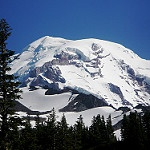

Prediction: glacier
Loading image: seg_data/seg_pred/seg_pred/17199.jpg


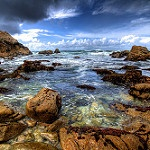

Prediction: glacier


In [125]:
for i, filename in enumerate(image_files):
    try:
        # Load image
        img_path = os.path.join(pred_dir, filename)
        print(f"Loading image: {img_path}")  # Debugging
        img = Image.open(img_path)

        # Save a copy for display at original size
        img_to_display = img.copy()

        # Resize for model input
        img = img.resize((32, 32))

        input_data = np.array(img, dtype=np.float32) / 255.0  # Normalize
        input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Perform post-processing (get class with highest probability)
        predicted_class = np.argmax(output_data)
        predicted_label = labels[predicted_class]

        # Display the image using IPython.display
        display(img_to_display)  # Display the original size image
        print(f"Prediction: {predicted_label}")

    except Exception as e:
        print(f"Error processing image {filename}: {e}")